<a href="https://colab.research.google.com/github/kreytos23/Phishing_RandomForest/blob/master/TrabajoTerminal1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import several libraries and modules for text processing, data manipulation, and email handling.
import re
import os
import nltk
import string
import mailbox
import pandas as pd
from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords
from email.header import decode_header
from nltk.tokenize import word_tokenize
from joblib import dump
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report, recall_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from imblearn.over_sampling import SMOTE
from sklearn.tree import export_graphviz
import graphviz


In [ ]:
#Se importan los correos de prueba de tipo phishing
phishing_emails = mailbox.mbox('/content/Correos/emails-phishing-nazario.mbox')

#Se importan los correos de prueba sin riesgos de phishing
valid_emails = mailbox.mbox('/content/Correos/emails-enron-legal-mails.mbox')
valid_emails1 = mailbox.mbox('/content/Correos/Spam250.mbox')
valid_emails2 = mailbox.mbox('/content/Correos/Spam350.mbox')
valid_emails3 = mailbox.mbox('/content/Correos/Spam400.mbox')


#Phishing Emails
phishing_K = mailbox.mbox('/content/Correos/Phising_Karla.mbox')
phishing_M = mailbox.mbox('/content/Correos/Phising_Milos.mbox')
phishing_emails_2 = mailbox.mbox('/content/Correos/Phishing_Alemon.mbox')
phishing_emails_3 = mailbox.mbox('/content/Correos/Phishing_Laura.mbox')
phishing_emails_4 = mailbox.mbox('/content/Correos/Phishing_Kaglee2.mbox')
phishing_emails_5 = mailbox.mbox('/content/Correos/Phishing_Sara.mbox')



In [ ]:
#Crear conjunto de correos seguros

combined_mbox = mailbox.mbox('/content/Correos/combinedSafe.mbox')
mbox_files = ['/content/Correos/emails-enron-legal-mails.mbox', '/content/Correos/Spam350.mbox']
for mbox_file in mbox_files:
  try:
      # Abrir el archivo mbox existente
      mbox = mailbox.mbox(mbox_file)
      # Añadir los mensajes del archivo mbox al archivo combinado
      for message in mbox:
          combined_mbox.add(message)
      mbox.close()
  except Exception as e:
      print(f"Error procesando {mbox_file}: {e}")

In [ ]:
#Crear conjunto de correos phishing

combinedPhishing_mbox = mailbox.mbox('/content/Correos/combinedPhishing.mbox')
mbox_files_phishing = ['/content/Correos/emails-phishing-nazario.mbox', '/content/Correos/Phising_Karla.mbox', '/content/Correos/Phising_Milos.mbox', '/content/Correos/Phishing_Kaglee2.mbox', '/content/Correos/Phishing_Laura.mbox', '/content/Correos/Phishing_Sara.mbox' , '/content/Correos/Phishing_Alemon.mbox']
for mbox_file in mbox_files_phishing:
  try:
      # Abrir el archivo mbox existente
      mbox = mailbox.mbox(mbox_file)
      # Añadir los mensajes del archivo mbox al archivo combinado
      for message in mbox:
          try:
            combinedPhishing_mbox.add(message)
          except:
            print("Error añadiendo mensaje")
      mbox.close()
  except Exception as e:
      print(f"Error procesando {mbox_file}: {e}")

Error añadiendo mensaje


In [ ]:
# Clase EmailParser se utiliza para extraer las características de los correos que se pasen por parámetros, características como URLs, No. de Datos adjuntos
# contenido HTML y contenido en texto plano
class EmailParser:
    urlRegex = r'https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=;]*)'
    emailRegex = r'([a-zA-Z0-9._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)'

# Constructor del método
    def __init__(self, email):
        self.email = email
        self.__extract_email_parts()

#This method iterates over the parts of the email message using the walk() method.
#It checks the content type of each part and based on that,
#extracts the text, HTML content, and counts the number of attachments.

    def __extract_email_parts(self):
        no_of_attachments = 0
        text = str(self.email['Subject']) + " "
        htmlDoc = ""
        for part in self.email.walk():
            content_type = part.get_content_type()
            if content_type == 'text/plain':
                text += str(part.get_payload())
            elif content_type == 'text/html':
                htmlDoc += part.get_payload()
            else:
                main_content_type = part.get_content_maintype()
                if main_content_type in ['image','application']:
                    no_of_attachments += 1
        self.text, self.html, self.no_of_attachments = text, htmlDoc, no_of_attachments

 #This method returns a list of URLs found in both the text and HTML content of the email.
 #It uses regular expressions and the urlRegex class variable to match and extract URLs from the text and HTML.

    def get_urls(self):
        text_urls = set(re.findall(EmailParser.urlRegex,self.text))
        html_urls = set(re.findall(EmailParser.urlRegex,self.html))
        return list(text_urls.union(html_urls))

    #This method returns the text content of the email. If HTML content is present
    def get_email_text(self):
        if(self.html != ""):
            soup = BeautifulSoup(self.html, "lxml")
            self.text += soup.text
        return self.text

    #This method returns the number of attachments found in the email
    def get_no_of_attachments(self):
        return self.no_of_attachments

    #This method returns the email address of the sender.
    #It retrieves the sender's information from the email parameter passed to the constructor.
    def get_sender_email_address(self):
        sender = self.email['From']
        try:
            emails = re.findall(EmailParser.emailRegex, sender)
        except:
            h = decode_header(self.email['From'])
            header_bytes = h[0][0]
            sender = header_bytes.decode('ISO-8859-1')
            emails = re.findall(EmailParser.emailRegex, sender)
        if(len(emails) != 0):
            return emails[len(emails)-1]
        else:
            return ''

    #This method returns the email address of the receiver.
    #It retrieves the receiver's information from the email parameter passed to the constructor.
    def get_receiver_email_address(self):
        receiver = self.email['To']
        try:
            emails = re.findall(EmailParser.emailRegex, receiver)
        except:
            h = decode_header(self.email['To'])
            header_bytes = h[0][0]
            receiver = header_bytes.decode('ISO-8859-1')
            emails = re.findall(EmailParser.emailRegex, receiver)
        if(len(emails) != 0):
            return emails[len(emails)-1]
        else:
            return ''

In [ ]:
#provide various utility methods for processing text, URLs, and email addresses
class StringUtil:

    dotRegex = r'\.'
    digitsRegex = r'[0-9]'
    ipAddressRegex = r'(?:[0-9]{1,3}\.){3}[0-9]{1,3}'
    dashesRegex = r'-'
    specialCharsRegex = r'[()@:%_\+~#?\=;]'
    words = Counter()
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))
    stemmer = nltk.PorterStemmer()
    punctuations = ['!','@','#','$','%','^','&','*','(',')','-','_','=','+',';',':',"'",'"','?','/','<','>','.',',','/','~','`']


    #This method takes a list of URLs as input and processes them.
    #It counts the number of dots, dashes, and special characters in each URL
    def process_urls(self,urls):
        noOfDots, noOfDashes, noOfSpecialChars, hasIpAddressInUrl, noOfIpAddress, noOfHttpsLinks = 0,0,0,0,0,0
        for url in urls:
            if url.startswith('https://'):
                noOfHttpsLinks += 1
            noOfDots += len(re.findall(StringUtil.dotRegex,url))
            noOfDashes += len(re.findall(StringUtil.dashesRegex,url))
            noOfSpecialChars += len(re.findall(StringUtil.specialCharsRegex,url))
            noOfIpAddress += len(re.findall(StringUtil.ipAddressRegex, url))
        if noOfIpAddress > 0:
            hasIpAddressInUrl = 1
        return len(urls), noOfDots, noOfDashes, noOfSpecialChars, hasIpAddressInUrl, noOfIpAddress, noOfHttpsLinks


    #This method takes a string of text as input and processes it. It performs several operations on the text, including converting it to lowercase,
    #removing escape sequences, removing punctuation and digits, tokenizing the text into individual words
    def process_text(self, text):
        text = text.lower()                    #lowercase
        text = re.sub(r'[\n\t\r]', ' ', text)  #remove escape sequences

        #remove punctuations
        punctuation = string.punctuation  # Get all punctuation marks
        translator = str.maketrans('', '', punctuation + string.digits)  # Create a translator to remove punctuation and digits
        text = text.translate(translator)  # Remove punctuation and digits using translate()

        #tokenize and stem words
        word_tokens = word_tokenize(text)
        filtered_text = []
        for w in word_tokens:
            if w not in StringUtil.stop_words:
                filtered_text.append(w)

        #count frequency of words
        word_counts = Counter(filtered_text)
        stemmed_word_count = Counter()
        for word, count in word_counts.items():
            stemmed_word = StringUtil.stemmer.stem(word)
            stemmed_word_count[stemmed_word] += count
        word_counts = stemmed_word_count
        StringUtil.words += word_counts
        return word_counts

    #This method takes an email address as input and processes it. It calculates various metrics related to the email address,
    #including its length, the counts of dots, dashes, special characters, digits, and subdomains
    def process_email_address(self, emailid):
        length, noOfDots, noOfDashes, noOfSpecialChars, noOfDigits, noOfSubdomains = 0,0,0,0,0,0

        length = len(emailid)
        if(length > 0):
            username, domain = emailid.split('@')
            noOfSubdomains = len(re.findall(StringUtil.dotRegex,domain)) - 1
            noOfDots = len(re.findall(StringUtil.dotRegex, username))
            noOfSpecialChars = len(re.findall(StringUtil.specialCharsRegex, username))
            noOfDashes = len(re.findall(StringUtil.dashesRegex, emailid))
            noOfDigits = len(re.findall(StringUtil.digitsRegex, emailid))

        return length, noOfDots, noOfDashes, noOfSpecialChars, noOfDigits, noOfSubdomains

        #This method returns the 1000 most common words encountered so far in the text processing.
        #It accesses the class variable StringUtil.words,
        #which is a Counter object that keeps track of word frequencies across all processed texts.
    def get_most_common_words(self):
        return StringUtil.words.most_common(1000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#StringUtil class and the EmailParser class to process a list of phishing emails and extract relevant features.
#It then adds the extracted features along with the corresponding class label to a pandas DataFrame named df1
nltk.download('punkt')
df1 =pd.DataFrame(columns=['text', 'lengthOfEmailId', 'noOfDotsInEmailId', 'noOfDashesInEmailId', 'noOfSpecialCharsInEmailId', 'noOfDigitsInEmailId', 'noOfSubdomainsInEmailId', 'noOfUrls', 'noOfDotsInUrls', 'noOfDashesInUrls', 'noOfSpecialCharsInUrls', 'hasIpAddressInUrls', 'noOfIpAddressInUrls', 'noOfHttpsLinks','no_of_attachments', 'senderAddr', 'class_label'])
stringUtil = StringUtil()
for email in combinedPhishing_mbox:
  try:
      emailParser = EmailParser(email)
      no_of_attachments = emailParser.get_no_of_attachments()
      emailid_features = stringUtil.process_email_address(emailParser.get_sender_email_address())
      urls_features = stringUtil.process_urls(emailParser.get_urls())
      word_dict = stringUtil.process_text(emailParser.get_email_text())
      senderAddr = emailParser.get_sender_email_address()
      df1.loc[len(df1)] = [word_dict, emailid_features[0], emailid_features[1], emailid_features[2], emailid_features[3], emailid_features[4], emailid_features[5], urls_features[0],urls_features[1],urls_features[2],urls_features[3],urls_features[4],urls_features[5], urls_features[6], no_of_attachments, senderAddr, 1]
  except Exception as e:
      print("Error parsing DF")
#get most common words from phishing emails
malicious_words = stringUtil.get_most_common_words()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Error parsing DF


In [ ]:
#Guardamos la lista de palabras en un archivo para exportar
import csv
with open('datos.csv', 'w', newline='') as archivo_csv:
    escritor = csv.writer(archivo_csv)
    escritor.writerows(malicious_words)

In [ ]:
df1.head()

,text,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpsLinks,no_of_attachments,senderAddr,class_label
0,"{'import': 1, 'account': 1, 'notic': 1, 'south...",29,0,0,1,3,0,2,5,0,2,1,1,1,1,identdep_op718@southtrust.com,1
1,"{'ebay': 9, 'account': 4, 'verif': 1, 'dear': ...",21,0,0,0,0,0,2,5,1,9,0,0,0,0,emailconfirm@ebay.com,1
2,"{'ebay': 2, 'account': 4, 'verif': 1, 'dear': ...",21,0,0,0,0,0,2,6,1,8,0,0,0,0,emailconfirm@ebay.com,1
3,"{'keybank': 2, 'custom': 2, 'confirm': 4, 'ide...",19,0,0,0,0,0,3,8,0,6,1,1,1,0,support@keybank.com,1
4,"{'keybank': 2, 'custom': 2, 'confirm': 4, 'ide...",19,0,0,0,0,0,3,8,0,6,1,1,1,0,support@keybank.com,1


In [ ]:
#shows the usage of the StringUtil class and the EmailParser class to process a list of valid emails and extract relevant features.
#It then adds the extracted features along with the corresponding class label to a new pandas DataFrame named

df2 =pd.DataFrame(columns=['text', 'lengthOfEmailId', 'noOfDotsInEmailId',
                           'noOfDashesInEmailId', 'noOfSpecialCharsInEmailId',
                           'noOfDigitsInEmailId', 'noOfSubdomainsInEmailId',
                           'noOfUrls', 'noOfDotsInUrls', 'noOfDashesInUrls',
                           'noOfSpecialCharsInUrls', 'hasIpAddressInUrls',
                           'noOfIpAddressInUrls', 'noOfHttpsLinks',
                           'no_of_attachments', 'senderAddr', 'class_label'])
stringUtil = StringUtil()
for email in combined_mbox:
    emailParser = EmailParser(email)
    no_of_attachments = emailParser.get_no_of_attachments()
    emailid_features = stringUtil.process_email_address(emailParser.get_sender_email_address())
    urls_features = stringUtil.process_urls(emailParser.get_urls())
    word_dict = stringUtil.process_text(emailParser.get_email_text())
    senderAddr = emailParser.get_sender_email_address()
    df2.loc[len(df2)] = [word_dict, emailid_features[0], emailid_features[1],
                         emailid_features[2], emailid_features[3],
                         emailid_features[4], emailid_features[5],
                         urls_features[0],urls_features[1],urls_features[2],
                         urls_features[3],urls_features[4],urls_features[5],
                         urls_features[6], no_of_attachments, senderAddr, 0]


In [ ]:
df2.head()

,text,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpsLinks,no_of_attachments,senderAddr,class_label
0,"{'pay': 2, 'well': 1, 'perform': 1, 'bonus': 1...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,phillip.allen@enron.com,0
1,"{'trade': 2, 'profit': 1, 'p': 1, 'allen': 1, ...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,phillip.allen@enron.com,0
2,"{'bonu': 2, 'expect': 1, 'confidenti': 1, 'joh...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,rob.milnthorp@enron.com,0
3,"{'trade': 2, 'profit': 1, 'p': 1, 'allen': 1, ...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,phillip.allen@enron.com,0
4,"{'pay': 2, 'well': 1, 'perform': 1, 'bonus': 1...",23,1,0,0,0,0,0,0,0,0,0,0,0,0,phillip.allen@enron.com,0


In [ ]:
promedios = df1.drop(columns=["class_label", "senderAddr", "text"]).mean()
print("Promedios de cada características en correos Phishing:")
print(promedios.round(1).to_string())

Promedios de cada características en correos Phishing:
lengthOfEmailId              25.5
noOfDotsInEmailId             0.3
noOfDashesInEmailId           0.3
noOfSpecialCharsInEmailId     0.1
noOfDigitsInEmailId           2.6
noOfSubdomainsInEmailId       0.1
noOfUrls                      6.1
noOfDotsInUrls               18.8
noOfDashesInUrls              2.6
noOfSpecialCharsInUrls       15.7
hasIpAddressInUrls            0.2
noOfIpAddressInUrls           0.3
noOfHttpsLinks                1.0
no_of_attachments             0.2


In [ ]:
promedios = df2.drop(columns=["class_label", "senderAddr", "text"]).mean()
print("Promedios de cada característica en correos Seguros:")
print(promedios.round(2).to_string())

Promedios de cada característica en correos Seguros:
lengthOfEmailId              22.32
noOfDotsInEmailId             0.80
noOfDashesInEmailId           0.03
noOfSpecialCharsInEmailId     0.02
noOfDigitsInEmailId           0.07
noOfSubdomainsInEmailId       0.10
noOfUrls                      3.87
noOfDotsInUrls               10.64
noOfDashesInUrls              2.25
noOfSpecialCharsInUrls       12.66
hasIpAddressInUrls            0.00
noOfIpAddressInUrls           0.00
noOfHttpsLinks                2.91
no_of_attachments             0.01


In [ ]:
df = pd.concat([df1,df2],axis=0, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7108 entries, 0 to 7107
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   text                       7108 non-null   object
 1   lengthOfEmailId            7108 non-null   int64 
 2   noOfDotsInEmailId          7108 non-null   int64 
 3   noOfDashesInEmailId        7108 non-null   int64 
 4   noOfSpecialCharsInEmailId  7108 non-null   int64 
 5   noOfDigitsInEmailId        7108 non-null   int64 
 6   noOfSubdomainsInEmailId    7108 non-null   int64 
 7   noOfUrls                   7108 non-null   int64 
 8   noOfDotsInUrls             7108 non-null   int64 
 9   noOfDashesInUrls           7108 non-null   int64 
 10  noOfSpecialCharsInUrls     7108 non-null   int64 
 11  hasIpAddressInUrls         7108 non-null   int64 
 12  noOfIpAddressInUrls        7108 non-null   int64 
 13  noOfHttpsLinks             7108 non-null   int64 
 14  no_of_at

In [ ]:
#adds a new column to the DataFrame df named 'noOfMaliciousWords'
#and populates it with the count of malicious words present in each email.
#It then removes the 'text' column from the DataFrame.

df['noOfMaliciousWords'] = df['text'].apply(lambda x:
                          len(set(x.keys()).intersection(set(dict(malicious_words).keys()))))
df = df.drop(columns=['text'])

In [ ]:
promedios = df.drop(columns=["class_label", "senderAddr"]).mean()
print("Promedios de cada característica en DataFrame Completo:")
print(promedios.round(2).to_string())

Promedios de cada característica en DataFrame Completo:
lengthOfEmailId              23.44
noOfDotsInEmailId             0.63
noOfDashesInEmailId           0.11
noOfSpecialCharsInEmailId     0.05
noOfDigitsInEmailId           0.96
noOfSubdomainsInEmailId       0.10
noOfUrls                      4.66
noOfDotsInUrls               13.51
noOfDashesInUrls              2.38
noOfSpecialCharsInUrls       13.73
hasIpAddressInUrls            0.08
noOfIpAddressInUrls           0.11
noOfHttpsLinks                2.24
no_of_attachments             0.06
noOfMaliciousWords           54.61


In [ ]:
df.head()

,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpsLinks,no_of_attachments,senderAddr,class_label,noOfMaliciousWords
0,29,0,0,1,3,0,2,5,0,2,1,1,1,1,identdep_op718@southtrust.com,1,6
1,21,0,0,0,0,0,2,5,1,9,0,0,0,0,emailconfirm@ebay.com,1,46
2,21,0,0,0,0,0,2,6,1,8,0,0,0,0,emailconfirm@ebay.com,1,28
3,19,0,0,0,0,0,3,8,0,6,1,1,1,0,support@keybank.com,1,71
4,19,0,0,0,0,0,3,8,0,6,1,1,1,0,support@keybank.com,1,71


In [ ]:
df.tail()

,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpsLinks,no_of_attachments,senderAddr,class_label,noOfMaliciousWords
7103,24,0,1,0,0,1,38,105,18,122,0,0,29,0,store-news@amazon.com.mx,0,58
7104,17,0,0,0,0,1,27,51,1,109,0,0,27,0,info@news.vans.mx,0,21
7105,24,0,0,0,0,1,4,9,3,11,0,0,4,0,michel@mail.nowisnao.com,0,19
7106,23,0,0,0,0,0,7,19,28,31,0,0,7,0,cursos@pablotilotta.com,0,22
7107,23,0,0,0,0,0,7,14,0,13,0,0,1,0,es@hostingerdomains.com,0,61


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7108 entries, 0 to 7107
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   lengthOfEmailId            7108 non-null   int64 
 1   noOfDotsInEmailId          7108 non-null   int64 
 2   noOfDashesInEmailId        7108 non-null   int64 
 3   noOfSpecialCharsInEmailId  7108 non-null   int64 
 4   noOfDigitsInEmailId        7108 non-null   int64 
 5   noOfSubdomainsInEmailId    7108 non-null   int64 
 6   noOfUrls                   7108 non-null   int64 
 7   noOfDotsInUrls             7108 non-null   int64 
 8   noOfDashesInUrls           7108 non-null   int64 
 9   noOfSpecialCharsInUrls     7108 non-null   int64 
 10  hasIpAddressInUrls         7108 non-null   int64 
 11  noOfIpAddressInUrls        7108 non-null   int64 
 12  noOfHttpsLinks             7108 non-null   int64 
 13  no_of_attachments          7108 non-null   int64 
 14  senderAd

In [ ]:
x = df.drop(columns=["class_label", "senderAddr"]).values
y = df["class_label"].values

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=34, test_size=0.2)

In [ ]:
model = RandomForestClassifier(random_state=45)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

# This line calculates and prints the prediction accuracy of the model by comparing the predicted labels y_pred
#The accuracy score represents the proportion of correctly predicted labels.
print('Prediction accuracy: ', accuracy_score(y_test, y_pred))

# This line calculates and prints the precision score of the model by comparing the predicted labels y_pred
#The precision score represents the ability of the classifier to correctly identify positive instances.
print('Precision Score: ', precision_score(y_test, y_pred))


Prediction accuracy:  0.9690576652601969
Precision Score:  0.9604743083003953


In [ ]:
# Asume que df es tu DataFrame de entrenamiento original
feature_names = df.drop(columns=["class_label", "senderAddr"]).columns.tolist()

# Diccionario para almacenar los umbrales de cada característica
thresholds = defaultdict(list)

# Recorre cada árbol en el modelo
for tree in model.estimators_:
    tree_thresholds = tree.tree_.threshold
    tree_features = tree.tree_.feature
    for feature, threshold in zip(tree_features, tree_thresholds):
        if feature != -2:  # -2 indica que no es un nodo de división
            feature_name = feature_names[feature]
            thresholds[feature_name].append(threshold)

# Convierte el diccionario a un DataFrame para análisis más sencillo
thresholds_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in thresholds.items()]))

# Imprime los umbrales promedio de cada característica
average_thresholds = thresholds_df.mean()
print(average_thresholds)

hasIpAddressInUrls            0.500000
noOfUrls                      9.798401
noOfDigitsInEmailId           1.708709
noOfMaliciousWords           43.035677
no_of_attachments             0.950000
noOfSpecialCharsInEmailId     0.644509
noOfSubdomainsInEmailId       0.661850
lengthOfEmailId              22.540171
noOfDotsInEmailId             0.606722
noOfDashesInEmailId           0.696489
noOfDotsInUrls               17.817273
noOfDashesInUrls              5.405527
noOfSpecialCharsInUrls       20.349686
noOfHttpsLinks                7.015533
noOfIpAddressInUrls           0.591575
dtype: float64


Accuracy Score: 0.9796061884669479
Precision Score: 0.9723320158102767
Recall Score: 0.9704142011834319
F1 Score: 0.9713721618953604
Feature Importances: [0.05390584 0.08959477 0.00690829 0.00484751 0.06542618 0.02121107
 0.16233664 0.21877593 0.04651849 0.15750075 0.02138659 0.02268281
 0.04975875 0.01299215 0.06615422]
Cross-validation Scores: [0.96483826 0.92405063 0.97116737 0.97818438 0.72273047]
Mean cross-validation Score: 0.9121942214977071
Classification Report: 
               precision    recall  f1-score   support

      Secure       0.98      0.98      0.98       915
    Phishing       0.97      0.97      0.97       507

    accuracy                           0.98      1422
   macro avg       0.98      0.98      0.98      1422
weighted avg       0.98      0.98      0.98      1422



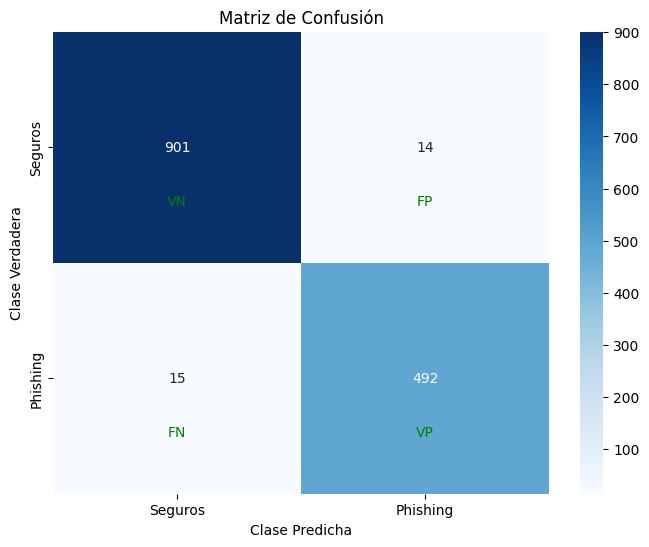

<ipython-input-46-92f5f3d3c980>:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')


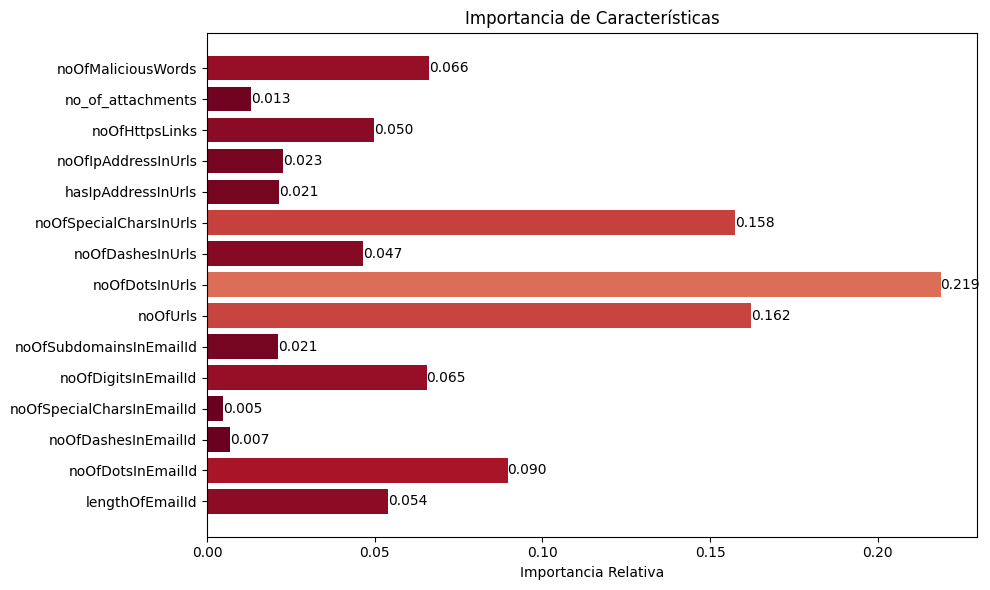

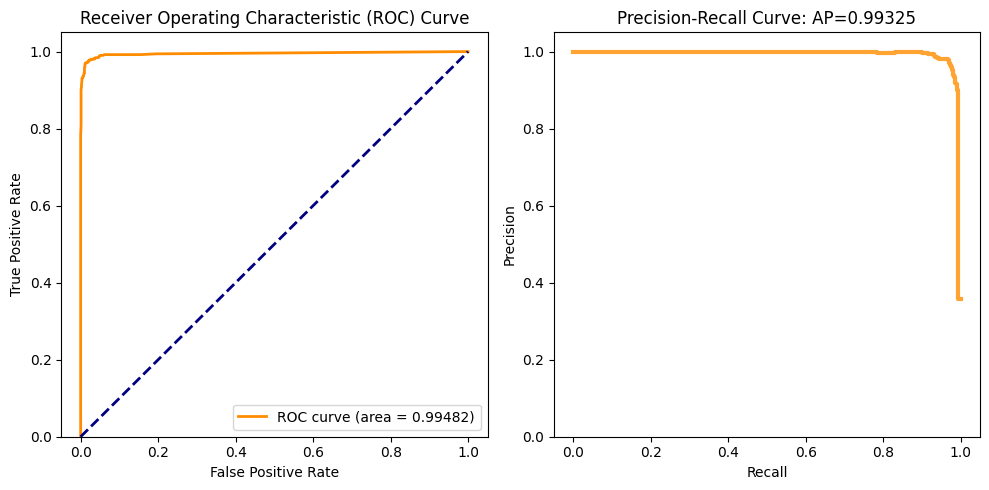

ROC AUC: 0.99482
Average Precision (AP): 0.99325


In [ ]:
#Metricas del modelo Base

print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
print(f"Precision Score: {precision_score(y_test, y_pred)}")
print(f"Recall Score: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
model_base_features = model.feature_importances_
print(f"Feature Importances: {model_base_features}")
scores_basemodel = cross_val_score(model, x, y, cv=5, scoring='accuracy')
print(f"Cross-validation Scores: {scores_basemodel}")
print(f"Mean cross-validation Score: {scores_basemodel.mean()}")
print(f'Classification Report: \n {classification_report(y_test, y_pred, target_names=["Secure", "Phishing"])}')

################################################################Confussion Matrix
class_names = ['Seguros', 'Phishing']  # Nombres de las clases

# Calculamos la matriz de confusión
cmatrix = confusion_matrix(y_test, y_pred)

# Crear una figura para la visualización
plt.figure(figsize=(8, 6))

# Crear el heatmap utilizando Seaborn
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')

# Añadir anotaciones para VP, VN, FP y FN
for i in range(cmatrix.shape[0]):
    for j in range(cmatrix.shape[1]):
        if i == j:
            label = 'VP' if i == 1 else 'VN'
        else:
            label = 'FP' if i == 0 else 'FN'
        plt.text(j + 0.5, i + 0.7, f'\n{label}', horizontalalignment='center', verticalalignment='center', color='green')

plt.show()

############################################################# IMPORTANCES
# Crear índices para las barras
indices = np.arange(len(model_base_features))

cmap = cm.get_cmap('RdBu')

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 6))
plt.title('Importancia de Características')
bars = plt.barh(indices, model_base_features, color=cmap(model_base_features), align='center')
plt.yticks(indices, df.drop(columns=["class_label", "senderAddr"]).columns.tolist())
plt.xlabel('Importancia Relativa')

# Añadir los valores de las importancias a la derecha de cada barra
for i in range(len(model_base_features)):
    plt.text(model_base_features[i], i, f'{model_base_features[i]:.3f}', va='center')

plt.tight_layout()

########################################################################### ROC Y RECALL AP

# Obtener las predicciones de probabilidad
y_scores_proba = model.predict_proba(x_test)[:, 1]  # Probabilidad de la clase positiva

# Calcular los valores de la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_scores_proba)
roc_auc = auc(fpr, tpr)

# Calcular los valores de la curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_scores_proba)
average_precision = average_precision_score(y_test, y_scores_proba)

# Visualizar la curva ROC
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Visualizar la curva Precision-Recall
plt.subplot(1, 2, 2)
plt.step(recall, precision, color='darkorange', alpha=0.8, lw=3, where='post')
#plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([-0.05, 1.05])
plt.title('Precision-Recall Curve: AP={0:0.5f}'.format(average_precision))

plt.tight_layout()
plt.show()

# Imprimir las métricas
print(f"ROC AUC: {roc_auc:.5f}")
print(f"Average Precision (AP): {average_precision:.5f}")

In [ ]:
dump(model, 'randomForestEmail_Spam350_ExtraPhishing_2.joblib')

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(x_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred_grid = best_model.predict(x_test)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy: 0.9701030832224289


Accuracy Score: 0.9683544303797469
Precision Score: 0.9514563106796117
Recall Score: 0.9607843137254902
F1 Score: 0.9560975609756097
Feature Importances: [0.05560527 0.10211305 0.00951205 0.00514631 0.04571699 0.01954751
 0.14286253 0.20584095 0.0636241  0.16986657 0.01145278 0.02127604
 0.05445496 0.01763434 0.07534654]


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Cross-validation Scores: [0.9676512  0.92967651 0.9697609  0.97888811 0.71287825]
Mean cross-validation Score: 0.9117709938624075
Classification Report: 
               precision    recall  f1-score   support

      Secure       0.98      0.97      0.98       912
    Phishing       0.95      0.96      0.96       510

    accuracy                           0.97      1422
   macro avg       0.96      0.97      0.97      1422
weighted avg       0.97      0.97      0.97      1422



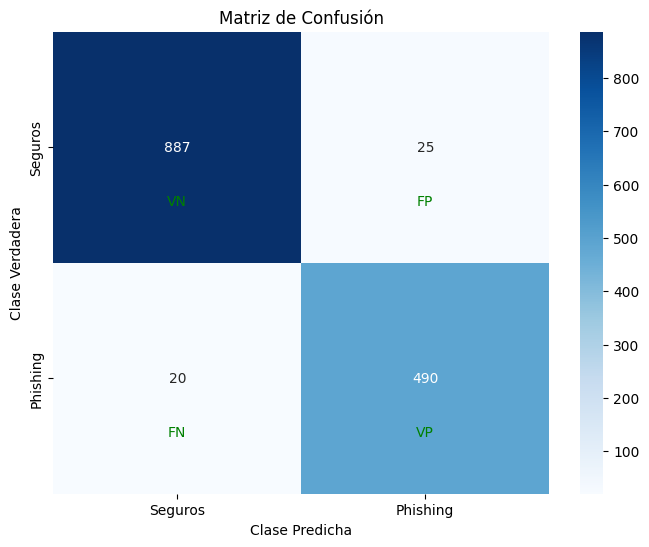

<ipython-input-28-d187ffb76672>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')


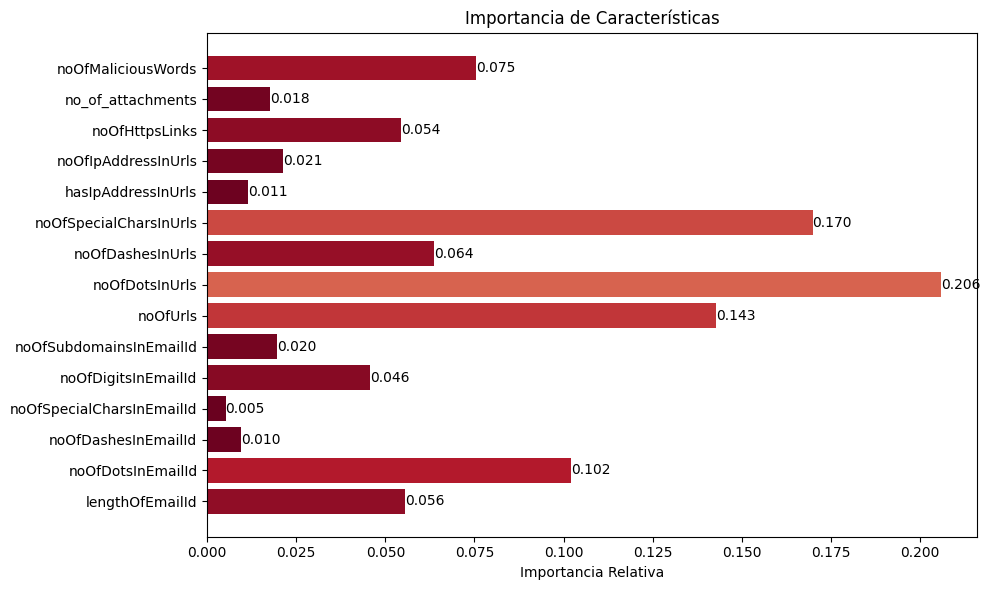

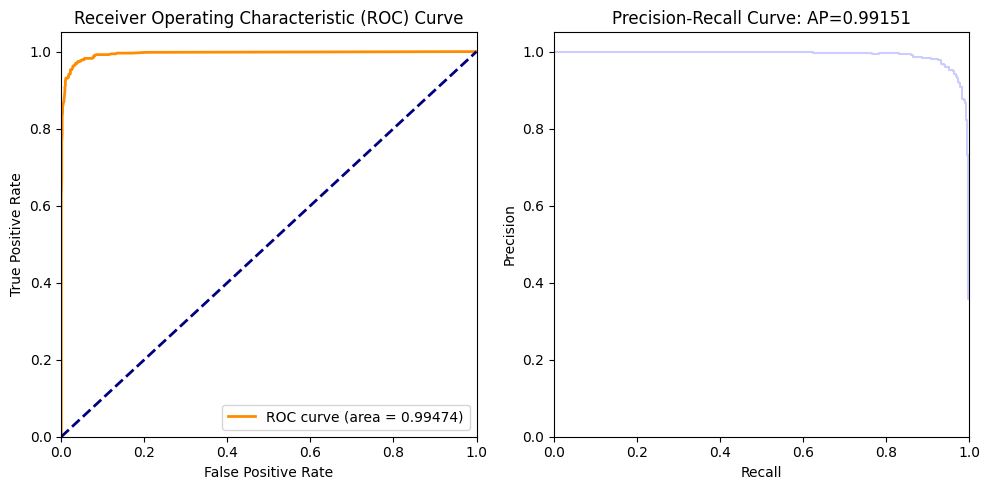

ROC AUC: 0.99474
Average Precision (AP): 0.99151


In [ ]:
#Metricas del modelo Refinado

print(f"Accuracy Score: {accuracy_score(y_test, y_pred_grid)}")
print(f"Precision Score: {precision_score(y_test, y_pred_grid)}")
print(f"Recall Score: {recall_score(y_test, y_pred_grid)}")
print(f"F1 Score: {f1_score(y_test, y_pred_grid)}")
model_base_features_grid = best_model.feature_importances_
print(f"Feature Importances: {model_base_features_grid}")
scores_gridmodel = cross_val_score(best_model, x, y, cv=5, scoring='accuracy')
print(f"Cross-validation Scores: {scores_gridmodel}")
print(f"Mean cross-validation Score: {scores_gridmodel.mean()}")
print(f'Classification Report: \n {classification_report(y_test, y_pred_grid, target_names=["Secure", "Phishing"])}')

################################################################Confussion Matrix
class_names = ['Seguros', 'Phishing']  # Nombres de las clases

# Calculamos la matriz de confusión
cmatrix = confusion_matrix(y_test, y_pred_grid)

# Crear una figura para la visualización
plt.figure(figsize=(8, 6))

# Crear el heatmap utilizando Seaborn
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')

# Añadir anotaciones para VP, VN, FP y FN
for i in range(cmatrix.shape[0]):
    for j in range(cmatrix.shape[1]):
        if i == j:
            label = 'VP' if i == 1 else 'VN'
        else:
            label = 'FP' if i == 0 else 'FN'
        plt.text(j + 0.5, i + 0.7, f'\n{label}', horizontalalignment='center', verticalalignment='center', color='green')

plt.show()

############################################################# IMPORTANCES
# Crear índices para las barras
indices = np.arange(len(model_base_features_grid))

cmap = cm.get_cmap('RdBu')

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 6))
plt.title('Importancia de Características')
bars = plt.barh(indices, model_base_features_grid, color=cmap(model_base_features_grid), align='center')
plt.yticks(indices, df.drop(columns=["class_label", "senderAddr"]).columns.tolist())
plt.xlabel('Importancia Relativa')

# Añadir los valores de las importancias a la derecha de cada barra
for i in range(len(model_base_features_grid)):
    plt.text(model_base_features_grid[i], i, f'{model_base_features_grid[i]:.3f}', va='center')

plt.tight_layout()

########################################################################### ROC Y RECALL AP

# Obtener las predicciones de probabilidad
y_scores_proba = best_model.predict_proba(x_test)[:, 1]  # Probabilidad de la clase positiva

# Calcular los valores de la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_scores_proba)
roc_auc = auc(fpr, tpr)

# Calcular los valores de la curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_scores_proba)
average_precision = average_precision_score(y_test, y_scores_proba)

# Visualizar la curva ROC
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Visualizar la curva Precision-Recall
plt.subplot(1, 2, 2)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
#plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.5f}'.format(average_precision))

plt.tight_layout()
plt.show()

# Imprimir las métricas
print(f"ROC AUC: {roc_auc:.5f}")
print(f"Average Precision (AP): {average_precision:.5f}")

In [ ]:
x = df.drop(columns=["class_label", "senderAddr"]).values
y = df["class_label"].values

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(x_train, y_train)

# Entrenar un modelo de Random Forest en los datos sobremuestreados
model_smote_redined = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy', max_depth=None, max_features='auto', min_samples_leaf=1, min_samples_split=2)
model_smote_redined.fit(X_resampled, y_resampled)

# Evaluar el modelo en el conjunto de prueba
y_pred_smote_redined = model_smote_redined.predict(x_test)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy Score: 0.9810126582278481
Precision Score: 0.9669260700389105
Recall Score: 0.980276134122288
F1 Score: 0.9735553379040157
Feature Importances: [0.05727754 0.11911438 0.00579162 0.00524461 0.05291715 0.01594228
 0.14285685 0.20493141 0.0634775  0.17356096 0.00593594 0.01636279
 0.04823036 0.01115668 0.07719992]


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Cross-validation Scores: [0.96837147 0.96971736 0.97981157 0.97777778 0.98249158]
Mean cross-validation Score: 0.9756339528075733
Classification Report: 
               precision    recall  f1-score   support

      Secure       0.99      0.98      0.99       915
    Phishing       0.97      0.98      0.97       507

    accuracy                           0.98      1422
   macro avg       0.98      0.98      0.98      1422
weighted avg       0.98      0.98      0.98      1422



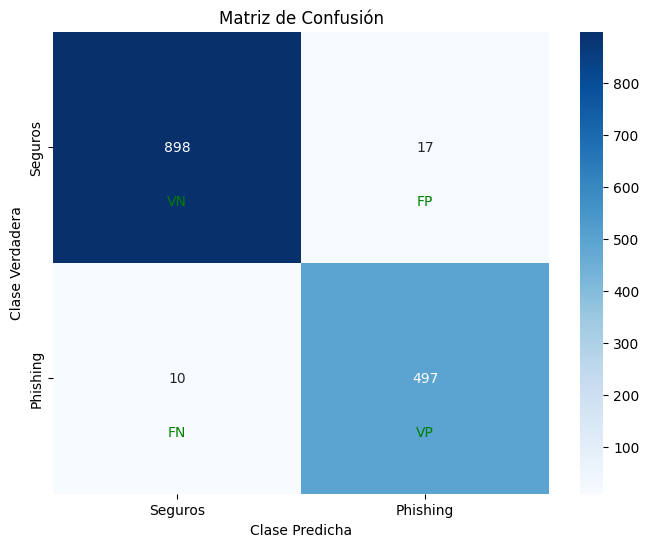

<ipython-input-41-8ba38278726d>:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')


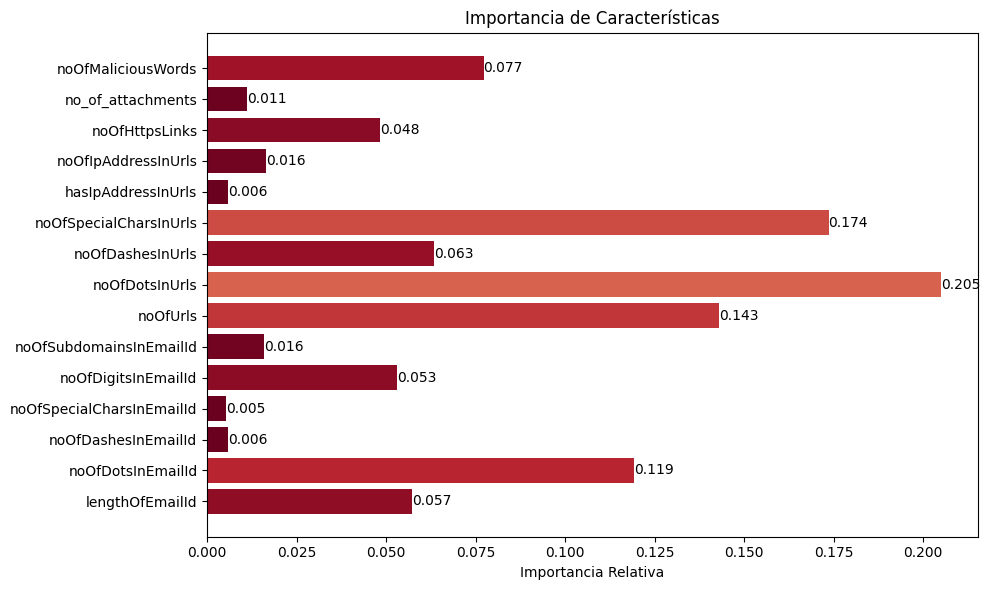

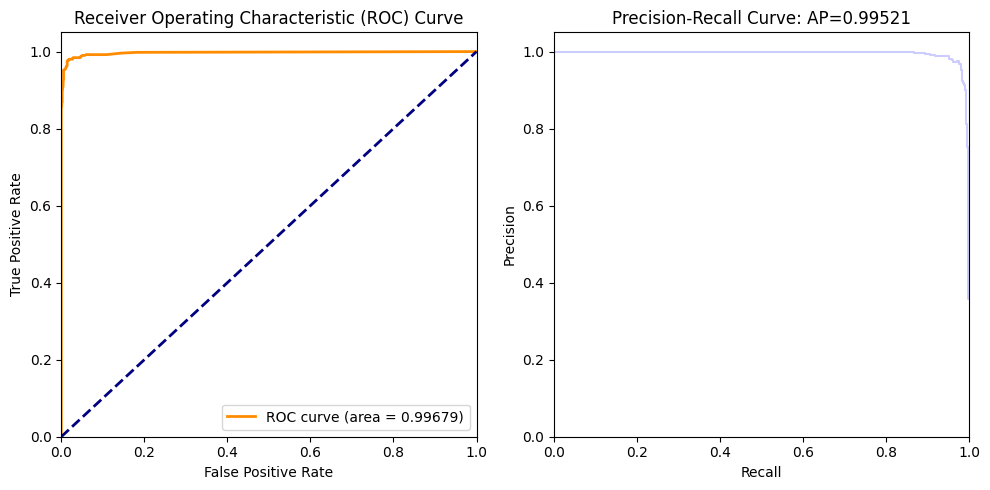

ROC AUC: 0.99679
Average Precision (AP): 0.99521


In [ ]:
#Metricas del modelo Refinado

print(f"Accuracy Score: {accuracy_score(y_test, y_pred_smote_redined)}")
print(f"Precision Score: {precision_score(y_test, y_pred_smote_redined)}")
print(f"Recall Score: {recall_score(y_test, y_pred_smote_redined)}")
print(f"F1 Score: {f1_score(y_test, y_pred_smote_redined)}")
model_features_refined_smote = model_smote_redined.feature_importances_
print(f"Feature Importances: {model_features_refined_smote}")
scores_gridmodel_smote = cross_val_score(model_smote_redined, X_resampled, y_resampled, cv=5, scoring='accuracy')
print(f"Cross-validation Scores: {scores_gridmodel_smote}")
print(f"Mean cross-validation Score: {scores_gridmodel_smote.mean()}")
print(f'Classification Report: \n {classification_report(y_test, y_pred_smote_redined, target_names=["Secure", "Phishing"])}')

################################################################Confussion Matrix
class_names = ['Seguros', 'Phishing']  # Nombres de las clases

# Calculamos la matriz de confusión
cmatrix = confusion_matrix(y_test, y_pred_smote_redined)

# Crear una figura para la visualización
plt.figure(figsize=(8, 6))

# Crear el heatmap utilizando Seaborn
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')

# Añadir anotaciones para VP, VN, FP y FN
for i in range(cmatrix.shape[0]):
    for j in range(cmatrix.shape[1]):
        if i == j:
            label = 'VP' if i == 1 else 'VN'
        else:
            label = 'FP' if i == 0 else 'FN'
        plt.text(j + 0.5, i + 0.7, f'\n{label}', horizontalalignment='center', verticalalignment='center', color='green')

plt.show()

############################################################# IMPORTANCES
# Crear índices para las barras
indices = np.arange(len(model_features_refined_smote))

cmap = cm.get_cmap('RdBu')

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 6))
plt.title('Importancia de Características')
bars = plt.barh(indices, model_features_refined_smote, color=cmap(model_features_refined_smote), align='center')
plt.yticks(indices, df.drop(columns=["class_label", "senderAddr"]).columns.tolist())
plt.xlabel('Importancia Relativa')

# Añadir los valores de las importancias a la derecha de cada barra
for i in range(len(model_features_refined_smote)):
    plt.text(model_features_refined_smote[i], i, f'{model_features_refined_smote[i]:.3f}', va='center')

plt.tight_layout()

########################################################################### ROC Y RECALL AP

# Obtener las predicciones de probabilidad
y_scores_proba = model_smote_redined.predict_proba(x_test)[:, 1]  # Probabilidad de la clase positiva

# Calcular los valores de la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_scores_proba)
roc_auc = auc(fpr, tpr)

# Calcular los valores de la curva Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_scores_proba)
average_precision = average_precision_score(y_test, y_scores_proba)

# Visualizar la curva ROC
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Visualizar la curva Precision-Recall
plt.subplot(1, 2, 2)
plt.step(recall, precision, color='b', alpha=0.2, where='post')
#plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve: AP={0:0.5f}'.format(average_precision))

plt.tight_layout()
plt.show()

# Imprimir las métricas
print(f"ROC AUC: {roc_auc:.5f}")
print(f"Average Precision (AP): {average_precision:.5f}")

In [ ]:
dump(model_smote_redined, 'randomForestEmail_Spam350_ExtraPhishing_200_Refined_Smote.joblib')


['randomForestEmail_Spam350_ExtraPhishing_200_Refined_Smote.joblib']

In [ ]:
  # Elegir un árbol al azar del bosque
tree = model_smote_redined.estimators_[50]

# Exportar a un archivo dot
dot_data = export_graphviz(tree, out_file=None,
                           feature_names=df.drop(columns=["class_label", "senderAddr"]).columns.tolist(),
                           class_names=["Non-phishing", "Phishing"],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree50")

'decision_tree50.pdf'

In [ ]:
scores = cross_val_score(best_model, x, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Cross-validation scores: [0.9676512  0.92967651 0.9697609  0.97888811 0.71287825]
Mean cross-validation score: 0.9117709938624075


In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, scoring='accuracy', random_state=42)
random_search.fit(x_train, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_}")

# Evaluar el mejor modelo en el conjunto de prueba
best_model_random = random_search.best_estimator_
y_pred = best_model_random.predict(x_test)
print(f"Test set accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")
importances_bestRandom =  best_model_random.feature_importances_
print(importances_bestRandom)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 20, 'criterion': 'gini'}
Best cross-validation accuracy: 0.9699267180150646
Test set accuracy: 0.960618846694796
Accuracy: 0.960618846694796
Precision: 0.933206106870229
Recall: 0.9588235294117647
F1 Score: 0.9458413926499033
[0.037913   0.09245758 0.00668844 0.00261722 0.04780987 0.01937934
 0.17794544 0.20342067 0.07709389 0.16654495 0.01938822 0.02283786
 0.05764696 0.01761331 0.05064325]


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

scores = cross_val_score(best_model_random, x, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {scores.mean()}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

Cross-validation scores: [0.9676512  0.92756681 0.96272855 0.97677692 0.72624912]
Mean cross-validation score: 0.9121945184300987


In [ ]:
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')
print(f'Classification Report: \n {classification_report(y_test, y_pred, target_names=["Secure", "Phishing"])}')

Confusion Matrix: 
 [[877  35]
 [ 21 489]]
Classification Report: 
               precision    recall  f1-score   support

      Secure       0.98      0.96      0.97       912
    Phishing       0.93      0.96      0.95       510

    accuracy                           0.96      1422
   macro avg       0.95      0.96      0.96      1422
weighted avg       0.96      0.96      0.96      1422



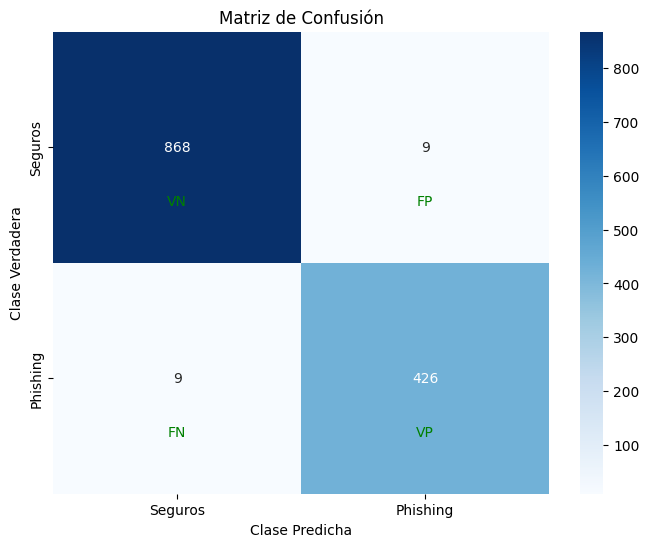

In [ ]:
class_names = ['Seguros', 'Phishing']  # Nombres de las clases

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear una figura para la visualización
plt.figure(figsize=(8, 6))

# Crear el heatmap utilizando Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Añadir títulos y etiquetas
plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')

# Añadir anotaciones para VP, VN, FP y FN
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i == j:
            label = 'VP' if i == 1 else 'VN'
        else:
            label = 'FP' if i == 0 else 'FN'
        plt.text(j + 0.5, i + 0.7, f'\n{label}', horizontalalignment='center', verticalalignment='center', color='green')

plt.show()

<ipython-input-21-8078c32e7b54>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdBu')


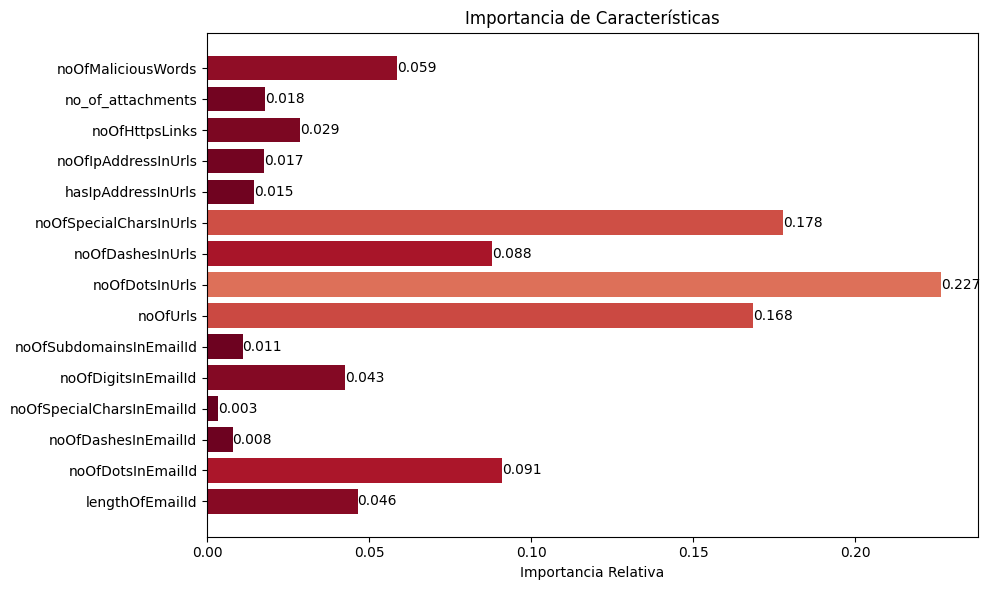

In [ ]:
# Crear índices para las barras
indices = np.arange(len(importances))

cmap = cm.get_cmap('RdBu')

# Crear un gráfico de barras horizontal
plt.figure(figsize=(10, 6))
plt.title('Importancia de Características')
bars = plt.barh(indices, importances, color=cmap(importances), align='center')
plt.yticks(indices, df.drop(columns=["class_label", "senderAddr"]).columns.tolist())
plt.xlabel('Importancia Relativa')

# Añadir los valores de las importancias a la derecha de cada barra
for i in range(len(importances)):
    plt.text(importances[i], i, f'{importances[i]:.3f}', va='center')

plt.tight_layout()

In [ ]:


# Elegir un árbol al azar del bosque
tree = model.estimators_[5]

# Exportar a un archivo dot
dot_data = export_graphviz(tree, out_file=None,
                           feature_names=df.drop(columns=["class_label", "senderAddr"]).columns.tolist(),
                           class_names=["Non-phishing", "Phishing"],
                           filled=True, rounded=True,
                           special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")

'decision_tree.pdf'

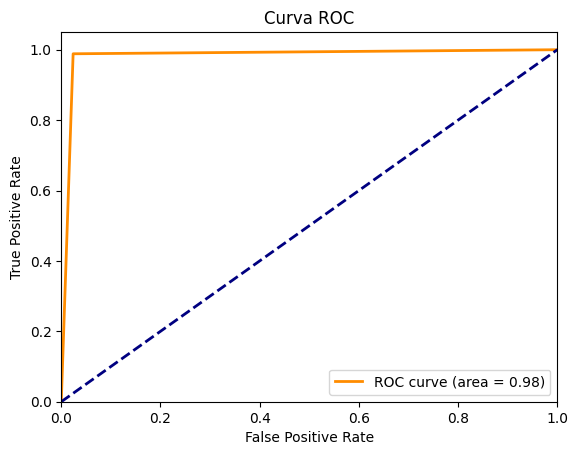

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(y_pred.tolist())
print(y_test.tolist())

[0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

In [ ]:
print(x_test.tolist())

[[20, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28], [29, 0, 0, 0, 0, 0, 3, 8, 1, 3, 0, 0, 1, 0, 103], [29, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 96], [17, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30], [49, 0, 1, 0, 16, 1, 1, 6, 0, 1, 0, 0, 0, 1, 23], [16, 0, 0, 0, 0, 0, 10, 22, 2, 18, 0, 0, 0, 0, 56], [23, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10], [46, 2, 0, 0, 8, 0, 2, 10, 2, 2, 0, 0, 0, 0, 53], [42, 3, 0, 1, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 68], [16, 0, 0, 0, 0, 0, 4, 13, 0, 9, 0, 0, 0, 0, 41], [20, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 31], [22, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 23], [18, 0, 0, 0, 2, 0, 1, 2, 0, 1, 0, 0, 0, 0, 47], [24, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11], [18, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 47], [21, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 42], [24, 0, 0, 0, 0, 1, 1, 8, 4, 13, 1, 1, 0, 0, 32], [14, 0, 0, 0, 0, 0, 4, 13, 0, 4, 0, 0, 0, 0, 14], [34, 0, 1, 0, 7, 1, 1, 6, 0, 1, 0, 0, 0, 1, 30], [24, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7], [24, 1, 0,

In [ ]:
test_emails = mailbox.mbox('/content/Correos/Spam.mbox')
dominios_permitidos = [".ipn", ".edu", ".unam"]

In [ ]:
df4 = pd.DataFrame(columns=['text', 'lengthOfEmailId', 'noOfDotsInEmailId', 'noOfDashesInEmailId', 'noOfSpecialCharsInEmailId', 'noOfDigitsInEmailId', 'noOfSubdomainsInEmailId', 'noOfUrls', 'noOfDotsInUrls', 'noOfDashesInUrls', 'noOfSpecialCharsInUrls', 'hasIpAddressInUrls', 'noOfIpAddressInUrls', 'noOfHttpsLinks','no_of_attachments', 'senderAddr', 'class_label', 'receiverAddr'])
stringUtil = StringUtil()
numInvalidAddr = 0
for email in test_emails:
    receiverAddr = emailParser.get_receiver_email_address()
    #if any(dominio in receiverAddr for dominio in dominios_permitidos):
    emailParser = EmailParser(email)
    no_of_attachments = emailParser.get_no_of_attachments()
    emailid_features = stringUtil.process_email_address(emailParser.get_sender_email_address())
    urls_features = stringUtil.process_urls(emailParser.get_urls())
    word_dict = stringUtil.process_text(emailParser.get_email_text())
    senderAddr = emailParser.get_sender_email_address()
    df4.loc[len(df4)] = [word_dict, emailid_features[0], emailid_features[1], emailid_features[2], emailid_features[3], emailid_features[4], emailid_features[5], urls_features[0],urls_features[1],urls_features[2],urls_features[3],urls_features[4],urls_features[5], urls_features[6], no_of_attachments, senderAddr, 0, receiverAddr]
    #else:
     # numInvalidAddr += 1
#print("Numero de Correos con Direcciones Invalidas:", numInvalidAddr)

In [ ]:
df4.head(13)

,text,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpsLinks,no_of_attachments,senderAddr,class_label,receiverAddr
0,"{'utfqcaforosdeciberseguridad': 1, 'explora': ...",35,0,0,0,0,0,5,8,1,13,0,0,5,0,contacto@redporlaciberseguridad.org,0,kreytos.pavi10@alumnos.ipn
1,"{'rider': 1, 'recap': 2, 'octob': 2, 'see': 1,...",16,0,0,0,0,0,39,77,22,88,0,0,26,0,noreply@uber.com,0,kreytos.pavi10@gmail.com
2,"{'remodela': 1, 'tu': 8, 'utfqhabitacicbnconla...",27,0,0,0,0,1,34,84,0,79,0,0,34,0,clientes@mailing.coppel.com,0,KREYTOS.PAVI10@GMAIL.COM
3,{'utfqffaakreytoscfreeregistrationforuniversev...,26,0,0,0,0,0,40,84,24,141,0,0,39,0,githubeducation@github.com,0,kreytos.pavi10@gmail.com
4,{'utfqffaaelevateyourscrumknowledgeajoinfreesf...,36,0,0,0,0,0,32,82,9,117,0,0,31,0,support@scrumstudycertifications.org,0,kreytos.pavi10@gmail.com
5,"{'utfqentrenaentodoclimaedefbf': 1, 'el': 4, '...",22,0,0,0,0,1,27,77,4,78,0,0,24,0,nike@official.nike.com,0,kreytos.pavi10@gmail.com
6,"{'utfbjalkcqcdcounlcfyla': 1, 'la': 3, 'mejor'...",29,1,0,0,0,2,19,44,1,47,0,0,17,0,kavak.mexico@mx.inb.kavak.com,0,kreytos.pavi10@gmail.com
7,{'utfqcagratisasistealforoexclusivodeciberseg'...,35,0,0,0,0,0,5,8,1,13,0,0,5,0,contacto@redporlaciberseguridad.org,0,kreytos.pavi10@gmail.com
8,{'utfqcbfsabescomotenerunacontrasecbasegura': ...,35,0,0,0,0,0,10,18,1,20,0,0,10,0,contacto@redporlaciberseguridad.org,0,kreytos.pavi10@gmail.com
9,{'utfqhayunaactualizacicbnenlacampacbaalaqu': ...,16,0,0,0,0,0,9,15,6,12,0,0,6,0,hola@donadora.co,0,kreytos.pavi10@gmail.com


In [ ]:
df4['noOfMaliciousWords'] = df4['text'].apply(lambda x: len(set(x.keys()).intersection(set(dict(malicious_words).keys()))))
df4 = df4.drop(columns=['text'])

In [ ]:
print(malicious_words)

[('x', 120368), ('account', 17181), ('ebay', 13628), ('email', 10577), ('pleas', 10170), ('paypal', 7318), ('inform', 6985), ('bank', 6690), ('messag', 6614), ('servic', 5215), ('thank', 5127), ('subject', 4772), ('updat', 4747), ('access', 4744), ('sent', 4683), ('may', 4505), ('secur', 4470), ('item', 4455), ('use', 4386), ('custom', 4331), ('would', 3933), ('question', 3881), ('member', 3811), ('us', 3798), ('polici', 3788), ('click', 3731), ('enron', 3653), ('protect', 3635), ('pm', 3542), ('agreement', 3452), ('onlin', 3444), ('time', 3379), ('receiv', 3257), ('need', 3214), ('chang', 3165), ('help', 3160), ('confirm', 3033), ('address', 3031), ('one', 3003), ('cc', 2990), ('new', 2911), ('includ', 2910), ('busi', 2905), ('right', 2882), ('user', 2850), ('limit', 2747), ('link', 2697), ('request', 2689), ('dear', 2675), ('follow', 2660), ('day', 2620), ('get', 2605), ('like', 2590), ('imag', 2512), ('respond', 2484), ('forward', 2445), ('power', 2440), ('work', 2408), ('client', 2

In [ ]:
df4.head(13)

,lengthOfEmailId,noOfDotsInEmailId,noOfDashesInEmailId,noOfSpecialCharsInEmailId,noOfDigitsInEmailId,noOfSubdomainsInEmailId,noOfUrls,noOfDotsInUrls,noOfDashesInUrls,noOfSpecialCharsInUrls,hasIpAddressInUrls,noOfIpAddressInUrls,noOfHttpsLinks,no_of_attachments,senderAddr,class_label,receiverAddr,noOfMaliciousWords
0,35,0,0,0,0,0,5,8,1,13,0,0,5,0,contacto@redporlaciberseguridad.org,0,kreytos.pavi10@alumnos.ipn,22
1,16,0,0,0,0,0,39,77,22,88,0,0,26,0,noreply@uber.com,0,kreytos.pavi10@gmail.com,46
2,27,0,0,0,0,1,34,84,0,79,0,0,34,0,clientes@mailing.coppel.com,0,KREYTOS.PAVI10@GMAIL.COM,40
3,26,0,0,0,0,0,40,84,24,141,0,0,39,0,githubeducation@github.com,0,kreytos.pavi10@gmail.com,69
4,36,0,0,0,0,0,32,82,9,117,0,0,31,0,support@scrumstudycertifications.org,0,kreytos.pavi10@gmail.com,86
5,22,0,0,0,0,1,27,77,4,78,0,0,24,0,nike@official.nike.com,0,kreytos.pavi10@gmail.com,27
6,29,1,0,0,0,2,19,44,1,47,0,0,17,0,kavak.mexico@mx.inb.kavak.com,0,kreytos.pavi10@gmail.com,22
7,35,0,0,0,0,0,5,8,1,13,0,0,5,0,contacto@redporlaciberseguridad.org,0,kreytos.pavi10@gmail.com,21
8,35,0,0,0,0,0,10,18,1,20,0,0,10,0,contacto@redporlaciberseguridad.org,0,kreytos.pavi10@gmail.com,21
9,16,0,0,0,0,0,9,15,6,12,0,0,6,0,hola@donadora.co,0,kreytos.pavi10@gmail.com,10


In [ ]:
xTest = df4.drop(columns=["class_label", "senderAddr", "receiverAddr"]).values
yTest = df4["class_label"].values

In [ ]:
from joblib import load

modelo_rf = load('/content/randomForestEmail.joblib')

In [ ]:
y_Prueba1 = modelo_rf.predict(xTest)

In [ ]:
print(y_Prueba1.tolist())

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]


In [ ]:
address = df4["senderAddr"].values
dfAnswer = pd.DataFrame({'Sender Address': address, "Results": y_Prueba1})

In [ ]:
dfAnswer.head(13)

,Sender Address,Results
0,contacto@redporlaciberseguridad.org,1
1,noreply@uber.com,1
2,clientes@mailing.coppel.com,1
3,githubeducation@github.com,1
4,support@scrumstudycertifications.org,1
5,nike@official.nike.com,1
6,kavak.mexico@mx.inb.kavak.com,1
7,contacto@redporlaciberseguridad.org,1
8,contacto@redporlaciberseguridad.org,1
9,hola@donadora.co,1


In [ ]:
json_resultado = dfAnswer.to_json(orient='index')
print(json_resultado)

{"0":{"Sender Address":"contacto@redporlaciberseguridad.org","Results":1},"1":{"Sender Address":"noreply@uber.com","Results":1},"2":{"Sender Address":"clientes@mailing.coppel.com","Results":1},"3":{"Sender Address":"githubeducation@github.com","Results":1},"4":{"Sender Address":"support@scrumstudycertifications.org","Results":1},"5":{"Sender Address":"nike@official.nike.com","Results":1},"6":{"Sender Address":"kavak.mexico@mx.inb.kavak.com","Results":1},"7":{"Sender Address":"contacto@redporlaciberseguridad.org","Results":1},"8":{"Sender Address":"contacto@redporlaciberseguridad.org","Results":1},"9":{"Sender Address":"hola@donadora.co","Results":1},"10":{"Sender Address":"hola@donadora.co","Results":1},"11":{"Sender Address":"mkt@emails.enviaflores.com","Results":1},"12":{"Sender Address":"contacto@redporlaciberseguridad.org","Results":0}}
